### In this notebook, we will use simple comparison of the image and Waldo to find the Waldo in the image. This method is a benchmark for later, machine learning methods.

In [74]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import cv2

In [75]:
# Get the data - every image from the 64 directory

train_ds= keras.utils.image_dataset_from_directory(
    '../data/src1/64',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(64, 64),
    batch_size=32)

print(train_ds.class_names)

# print both class names and the number of images in each class

for i in range(len(train_ds.class_names)):
    print(train_ds.class_names[i], len(train_ds.file_paths[i]))


Found 5376 files belonging to 2 classes.
Using 4301 files for training.
['notwaldo', 'waldo']
notwaldo 34
waldo 36


In [76]:
# Get the Waldo image as an rgb array
Waldos = []

Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/3.png').convert('RGB')))
Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/5.png').convert('RGB')))
Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/6.png').convert('RGB')))
Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/9.png').convert('RGB')))
Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/14.png').convert('RGB')))
Waldos.append(keras.utils.img_to_array(Image.open('../data/src2/OnlyWaldoHeads/16.png').convert('RGB')))

Waldos = np.array(Waldos)



print(Waldos.shape)

(6,)


/var/folders/w4/xs9m4t1j28598sp65xft3k1h0000gn/T/ipykernel_8248/2439471844.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Waldos = np.array(Waldos)


In [ ]:
# use cv2 to find the Waldo in the image

def findWaldo(image, waldo):
    result = cv2.matchTemplate(image, waldo, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    h, w, _ = waldo.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right, 255, 2)
    return image

In [ ]:
# get the first image from the dataset
for images, labels in train_ds.take(1):
    image = images[0].numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    for waldo in Waldos:
        image = findWaldo(image, waldo)
    plt.imshow(image)
    plt.show()

In [80]:
def get_waldo_locations(image, waldo):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Convert the waldo image to grayscale
    gray_waldo = cv2.cvtColor(waldo, cv2.COLOR_BGR2GRAY)
    # Get the width and height of the waldo image
    w, h = gray_waldo.shape[::-1]
    # Match the waldo image to the image
    res = cv2.matchTemplate(gray_image, gray_waldo, cv2.TM_CCOEFF_NORMED)
    # Set a threshold
    threshold = 0.8
    # Get the locations of the waldo image
    loc = np.where(res >= threshold)
    # Draw a rectangle around the waldo image
    for pt in zip(*loc[::-1]):
        cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)
    return image

In [78]:
# Slide the Waldo image over the data

def find_waldo_in_img(waldos, img):
    min_res = None
    min_val = None
    min_waldo = None
    min_idx = None
    
    for waldo in waldos:
        waldo = waldo / 255.0
        img = img / 255.0
        waldo_h, waldo_w, _ = waldo.shape
        img_h, img_w, _ = img.shape
        # for each possible position of the waldo image calculate the difference between the waldo image and the image
        # and sum the differences
        # return the position with the smallest difference and matrix of differences
        result = np.zeros((img_h - waldo_h, img_w - waldo_w))
        for i in range(img_h - waldo_h):
            for j in range(img_w - waldo_w):
                result[i, j] = np.sum(np.abs(img[i:i + waldo_h, j:j + waldo_w] - waldo))
        min_local = np.unravel_index(np.argmin(result), result.shape)
        if min_res is None or np.min(result) < min_val:
            min_res = result    
            min_val = np.min(result)
            min_waldo = waldo
            min_idx = min_local
    return min_res, min_val, min_waldo, min_idx

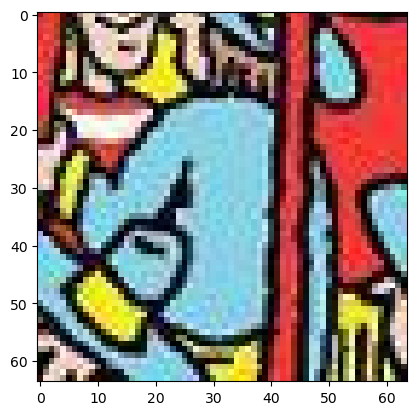

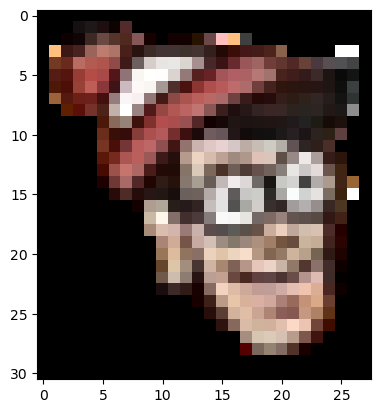

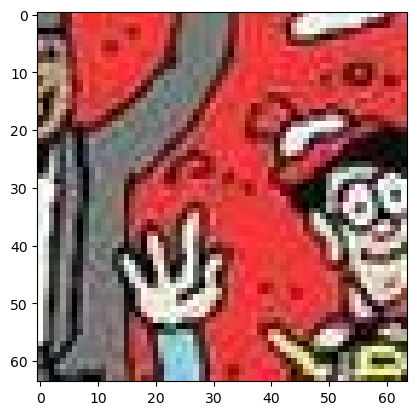

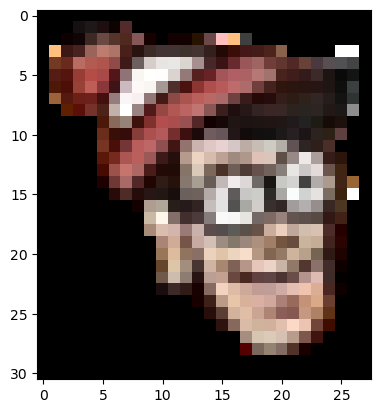

In [83]:
# Calculate the average minimal difference in images with Waldo and without Waldo

# split the data into images with Waldo and without Waldo

sum_waldo = 0
sum_no_waldo = 0
count_waldo = 0
count_no_waldo = 0

batches_tested = 0

for image_batch, labels_batch in train_ds:
    # if batch has no images with Waldo, skip it
    if np.sum(labels_batch) == 0:
        continue
    batches_tested += 1
    for i in range(len(image_batch)):
        if labels_batch[i] == 1:
            count_waldo += 1
            res, min_val, min_waldo, min_idx = find_waldo_in_img(Waldos, image_batch[i])
            sum_waldo += min_val
            # print the image with the Waldo
            print(min_idx)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.show()
            plt.imshow(min_waldo)
            plt.show()
        else:
            count_no_waldo += 1
            res, min_val, min_waldo, min_idx = find_waldo_in_img(Waldos, image_batch[i])
            sum_no_waldo += min_val
    # print(count_waldo, count_no_waldo, batches_tested)
    if batches_tested >= 10:
        break

if count_waldo != 0:
    print(sum_waldo/count_waldo)
if count_no_waldo != 0:
    print(sum_no_waldo/count_no_waldo)
    